## What is OMSnx?

> OSMnx is a Python package that lets you download geospatial data from OpenStreetMap and model, project, visualize, and analyze real-world street networks and any other geospatial geometries. 

OSMnx provides tools for
* Downloading geospatial data from OpenStreetMap (OSM)
    * Street network (with metadata)
    * Points of interest (e.g., stores)
* Modeling OSM street networks as NetworkX graphs
* (Street-)network simplification and clean up
* Basic routing
* Visualization

It bases on
* NetworkX (street network representation)
* GeoPandas (collections of geometries25)
* Shapely (geometry representation)

## OSMnx Tutorial

Case study: How well is waste container coverage of the city of munich. Steps:

In [ ]:
* Get boundaries/area of munich
* Find all waste containers within this area
* Determine the area covered by these

First, import the required libraries:

In [4]:
# Hide warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import geopandas as gpd
import osmnx as osm
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt

# Display plots in notebook
%matplotlib inline

/home/patrick/Code/live-coding-tutorial/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Getting boundaries of Munich

OSMnx provides the `geocode_to_gdf()` function to query OSM:

> Retrieve place(s) by name or ID from the Nominatim API as a GeoDataFrame. You can query by place name or OSM ID. If querying by place name, the query argument can be a string or structured dict, or a list of such strings/dicts to send to geocoder.
    
#### Parameters
* **query** : `string` or dict or list query string(s) or structured dict(s) to geocode
* **which_result** : `int`, which geocoding result to use. if None, auto-select the first (Multi)Polygon or raise an error if OSM doesn't return one. to get the top match regardless of geometry type, set which_result=1
* **by_osmid** : `bool`, if True, handle query as an OSM ID for lookup rather than text search
* **buffer_dist** : `float`, distance to buffer around the place geometry, in meters
* **Returns**: a `GeoDataFrame` with one row for each query

Lets utilize it to get the boundaries of the city of munich.

In [14]:
munich = osm.geocode_to_gdf({
    'city': 'München',
    'state': 'Bayern',
    'Country': 'Deutschland'
})

munich

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"MULTIPOLYGON (((11.36078 48.15807, 11.36085 48...",48.248116,48.061624,11.722908,11.360777,255497440,relation,62428,48.137108,11.575382,"Munich, Bavaria, Germany",boundary,administrative,0.746211


We can now use geopandas to plot the area:

<AxesSubplot:>

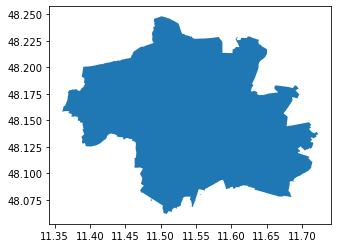

In [3]:
munich.plot()

## Getting geospatial data

OSMnx is not limited to querying for boundaries. Instead, we can query (arbitrary) data from [OSM](https://wiki.openstreetmap.org/wiki/Map_features) based on ***tags***.

Let's find all (glass) waste containers in munich:

In [2]:
# We can query for arbitrary objects using tags:
containers = osm.geometries_from_place('München, Bayern', {'amenity': 'recycling'})
print(len(containers))
containers.head(4)

1089


,unique_id,osmid,element_type,amenity,recycling:cans,recycling:clothes,recycling:glass,recycling_type,geometry,location,...,recycling:computers,recycling:fluorescent_tubes,recycling:mobile_phones,recycling:paint,recycling:rubble,addr:housename,layer,building:levels,height,roof:shape
0,node/21584473,21584473,node,recycling,yes,yes,yes,container,POINT (11.63877 48.17393),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node/48053986,48053986,node,recycling,yes,yes,NaN,container,POINT (11.59985 48.20554),overground,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node/51971057,51971057,node,recycling,yes,yes,NaN,container,POINT (11.60533 48.20207),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node/115721294,115721294,node,recycling,NaN,yes,no,container,POINT (11.54579 48.13728),overground,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

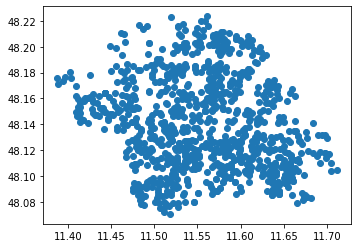

In [65]:
containers.plot()

**Caveat**: `amenity: recycling` comprises not only glass waste containers *(Know your data!)*

In [3]:
non_containers = containers[containers['recycling_type'] != 'container']
print(len(non_containers))
non_containers.head(4)

73


/home/patrick/Code/live-coding-tutorial/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,unique_id,osmid,element_type,amenity,recycling:cans,recycling:clothes,recycling:glass,recycling_type,geometry,location,...,recycling:computers,recycling:fluorescent_tubes,recycling:mobile_phones,recycling:paint,recycling:rubble,addr:housename,layer,building:levels,height,roof:shape
32,node/224094533,224094533,node,recycling,yes,yes,yes,centre,POINT (11.62278 48.22681),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,node/289205704,289205704,node,recycling,NaN,NaN,NaN,NaN,POINT (11.48383 48.17252),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
211,node/342848810,342848810,node,recycling,yes,yes,yes,NaN,POINT (11.64356 48.17262),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
250,node/370039058,370039058,node,recycling,yes,yes,yes,NaN,POINT (11.56664 48.08650),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Any ideas?

Let's try combining tags:

In [6]:
actual_containers = osm.geometries_from_place('München, Bayern', {'amenity': 'recycling', 'recycling_type': 'container'})
len(actual_containers)

/home/patrick/Code/live-coding-tutorial/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1089

In [7]:
containers = containers[containers['recycling_type'] == 'container']
containers.head(4)

/home/patrick/Code/live-coding-tutorial/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,unique_id,osmid,element_type,amenity,recycling:cans,recycling:clothes,recycling:glass,recycling_type,geometry,location,...,recycling:computers,recycling:fluorescent_tubes,recycling:mobile_phones,recycling:paint,recycling:rubble,addr:housename,layer,building:levels,height,roof:shape
0,node/21584473,21584473,node,recycling,yes,yes,yes,container,POINT (11.63877 48.17393),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node/48053986,48053986,node,recycling,yes,yes,NaN,container,POINT (11.59985 48.20554),overground,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node/51971057,51971057,node,recycling,yes,yes,NaN,container,POINT (11.60533 48.20207),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node/115721294,115721294,node,recycling,NaN,yes,no,container,POINT (11.54579 48.13728),overground,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Working with Geospatial data

#### => How well is munich covered?

In [13]:
# Print container locations over munich map
ax = munich.plot()
containers.plot(ax=ax, color='r')

NameError: name 'munich' is not defined

In [6]:
# Lets try to plot coverage
areas_covered = containers.buffer(500)
ax = munich.plot()
areas_covered.plot(ax=ax, color='r')

<ipython-input-6-4cc2fb4e3ff3>:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas_covered = containers.buffer(500)


NameError: name 'munich' is not defined

**Problem**: We buffer by a lat/long of 500 meters!

Again, OSMnx to the rescue! We can *project* `GeoDataFrames` into different coordinate reference systems (CRS), i.e., one based on meters:

In [9]:
# Containers is in lat/lon! => Project to meters
containers_meters = osm.project_gdf(containers)
display(containers_meters.head(4))

,unique_id,osmid,element_type,amenity,recycling:cans,recycling:clothes,recycling:glass,recycling_type,geometry,location,...,recycling:computers,recycling:fluorescent_tubes,recycling:mobile_phones,recycling:paint,recycling:rubble,addr:housename,layer,building:levels,height,roof:shape
0,node/21584473,21584473,node,recycling,yes,yes,yes,container,POINT (696170.124 5338999.612),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node/48053986,48053986,node,recycling,yes,yes,NaN,container,POINT (693157.895 5342413.372),overground,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node/51971057,51971057,node,recycling,yes,yes,NaN,container,POINT (693578.595 5342041.729),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node/115721294,115721294,node,recycling,NaN,yes,no,container,POINT (689393.190 5334692.733),overground,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

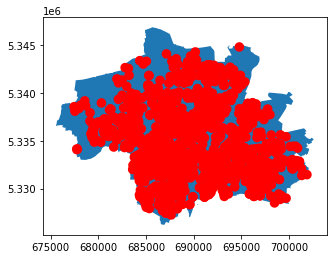

In [15]:
areas_covered = containers_meters.buffer(500)
munich_meters = osm.project_gdf(munich)
ax = munich_meters.plot()
areas_covered.plot(ax=ax, color='r')

## Answering the question

#### How well is munich covered by waste disposal containers?

<AxesSubplot:>

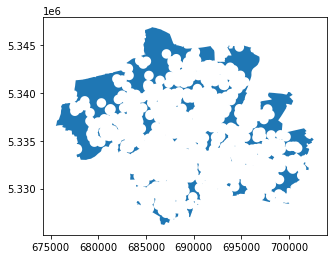

In [29]:
# Get uncovered area
covered_area = areas_covered.unary_union
uncovered_area = munich_meters.difference(covered_area)
uncovered_area.plot()

In [32]:
print(f'Uncovered area: {uncovered_area.area[0]}, of total: {munich_meters.area[0]} => {(uncovered_area.area[0] / munich_meters.area[0] * 100):.2f}%')

Uncovered area: 79436569.97489403, of total: 310732217.87308306 => 25.56%


### Overview of geopandas/shapely methods
See further: [Documentation](https://shapely.readthedocs.io/en/latest/manual.html)

#### Construction
* buffer
* unary_union
* convex_hull

#### Set theoretic operations
* difference
* intersection
* union
* centroid

#### Geospatial relations
* contains
* covers
* intersects

## Getting the street network

In [17]:
munich_streets = osm.graph_from_place('Maxvorstadt, Munich, Germany', network_type='drive')
# What are we dealing with?
print(type(munich_streets))
# Get some info on the graph
print(nx.info(munich_streets))

/home/patrick/Code/live-coding-tutorial/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'networkx.classes.multidigraph.MultiDiGraph'>
Name: 
Type: MultiDiGraph
Number of nodes: 349
Number of edges: 784
Average in degree:   2.2464
Average out degree:   2.2464


/home/patrick/Code/live-coding-tutorial/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


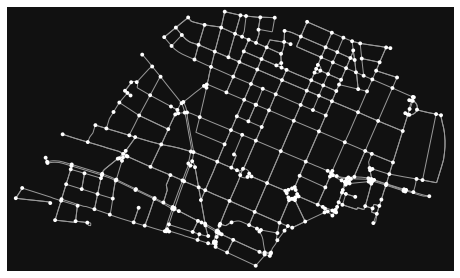

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [18]:
osm.plot_graph(munich_streets)

What data does this graph carry?

In [33]:
nodes, edges = osm.graph_to_gdfs(munich_streets)
display(nodes.head(4))
display(edges.head(4))

NameError: name 'munich_streets' is not defined

Street networks as returned by OSMnx are just NetworkX graphs with additional data!

** => We can use all of NetworkX's functions on the street network! **

In [19]:
top_nodes = sorted(munich_streets.degree, key=lambda x: x[1], reverse=True)[:10]
top_nodes

/home/patrick/Code/live-coding-tutorial/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(363191, 8),
 (1954405, 8),
 (1955467, 8),
 (1955499, 8),
 (1955504, 8),
 (1955506, 8),
 (1956111, 8),
 (6730035, 8),
 (6730036, 8),
 (6730038, 8)]

/home/patrick/Code/live-coding-tutorial/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


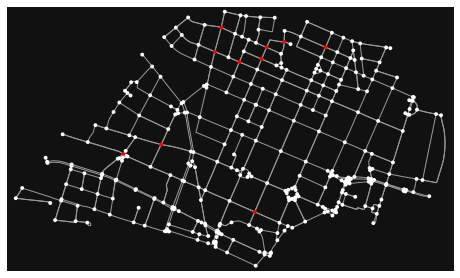

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [21]:
osm.plot_graph(munich_streets, node_color=['r' if node in top_nodes else 'w' for node in munich_streets])

Let's take a closer look on the network...

/home/patrick/Code/live-coding-tutorial/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


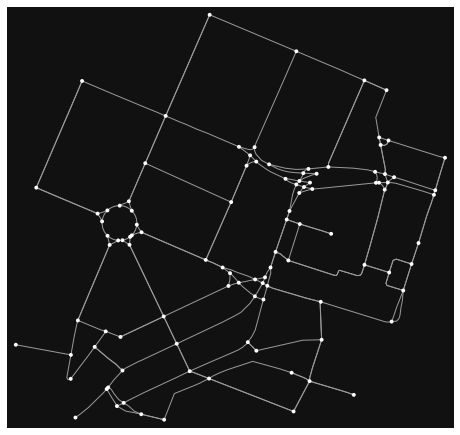

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [253]:
karolinenplatz_coords = (48.145136, 11.572600)
karolinenplatz = osm.graph_from_point(karolinenplatz_coords, dist=500, network_type='drive')
osm.plot_graph(karolinenplatz)

In [254]:
osm.plot_graph_folium(karolinenplatz, zoom=15, fit_bounds=False)

/home/patrick/Code/live-coding-tutorial/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


 ** Lot's of superfluous nodes! **

OSMnx already does ***some*** sparsification in the background:

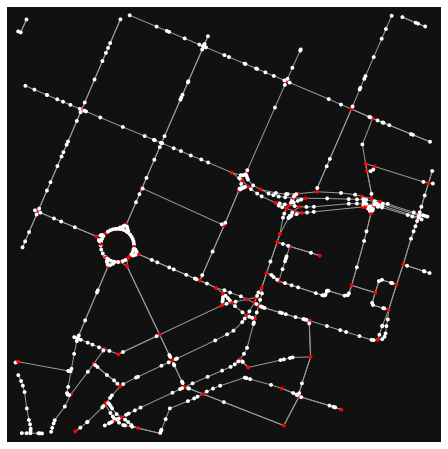

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [255]:
raw_karolienplatz = osm.graph_from_point(karolinenplatz_coords, network_type='drive', dist=500,
    simplify=False, # Discard intermediate nodes
    retain_all=True # Keep all connected components
)
osm.plot_graph(raw_karolienplatz, node_color=['w' if node in karolinenplatz else 'r' for node in raw_karolienplatz])

/home/patrick/Code/live-coding-tutorial/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


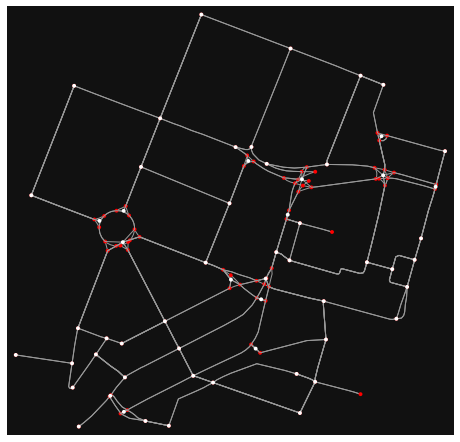

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [256]:
# But we can do better!
projected_karolienplatz = osm.project_graph(karolinenplatz)
clean_karolienplatz = osm.consolidate_intersections(projected_karolienplatz, rebuild_graph=True, tolerance=15, dead_ends=False)
fig, ax = osm.plot_graph(projected_karolienplatz, node_color='r', show=False, close=False)
osm.plot_graph(clean_karolienplatz, ax=ax)

## Basic routing

OSMnx provides facets for basic routing: `shortest_path(G, origin, dest, weight='length')`. Here, `origin` and `dest` are nodes of the graph (i.e., of type `osmid`).

In [23]:
query = osm.geocode_to_gdf(['Arcisstraße 21, 80333 München', 'Maßmannstraße 8, 80333 München'])
display(query)
university, park = (query.iloc[0], query.iloc[1])

/home/patrick/Code/live-coding-tutorial/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"POLYGON ((11.56561 48.14836, 11.56746 48.14785...",48.151406,48.147706,11.569907,11.565609,122493085,way,144291476,48.149555,11.567753,"Technical University Munich, 21, Arcisstraße, ...",amenity,university,0.874239
1,"POLYGON ((11.55952 48.15168, 11.55961 48.15161...",48.151763,48.151609,11.559762,11.559524,113698655,way,106529828,48.151686,11.559643,"8, Maßmannstraße, Maßmannbergl, Bezirksteil Ma...",building,yes,0.221000


We need to map these locations to nodes in our street network. OSMnx provides the `get_nearest_node(graph, (lat, lon))` function for this.

In [24]:
university_node = osm.get_nearest_node(munich_streets, (university.lat, university.lon))
park_node = osm.get_nearest_node(munich_streets, (park.lat, park.lon))
print(university_node, park_node)

345553442 246879854


/home/patrick/Code/live-coding-tutorial/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


This gives us the OSM ID's of the closest node(s).

We can use these with the shortest path function:

/home/patrick/Code/live-coding-tutorial/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[345553442, 21457470, 1954396, 4972204765, 4972221472, 1955498, 246879854]

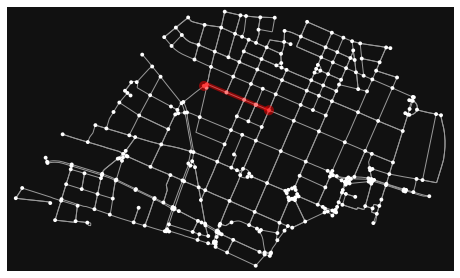

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [25]:
shortest_path = osm.shortest_path(munich_streets, orig=university_node, dest=park_node, weight='length')
display(shortest_path)

osm.plot_graph_route(munich_streets, route=shortest_path)

Finally, we can get the length of the shortest path:

In [271]:
route_length = osm.utils_graph.get_route_edge_attributes(munich_streets, shortest_path, 'length')
print(f'Length of edges: {route_length}, total: {sum(route_length)}')

Length of edges: [106.411, 3.919, 95.22699999999999, 146.704, 162.142, 24.176000000000002], total: 538.5790000000001


/home/patrick/Code/live-coding-tutorial/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Putting it together: Diet-aware routing

Let's design a routing engine that tries to minimize the number of (fast-food) restaurants the route visits. For this purpose we need to:

* Get the street network
* Fetch the locations of fast food restaurants
* Determine which streets should be avoided
* Find shortest paths accordingly

We start by assembling the street network:

/home/patrick/Code/live-coding-tutorial/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


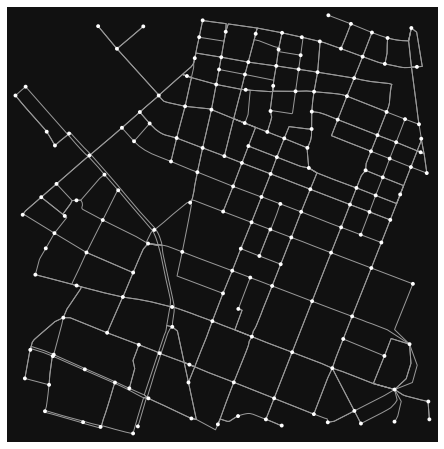

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [27]:
network = osm.graph_from_address('Maxvorstadt, Munich, Germany', network_type='drive')
# We'll want to work with reasonable distances
network = osm.project_graph(network)
# Simplfy intersections
network = osm.consolidate_intersections(network, rebuild_graph=True, dead_ends=False, tolerance=30)

osm.plot_graph(network)

We'll also need speeds. Here, we can again rely on built-in OSMnx functions.

/home/patrick/Code/live-coding-tutorial/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


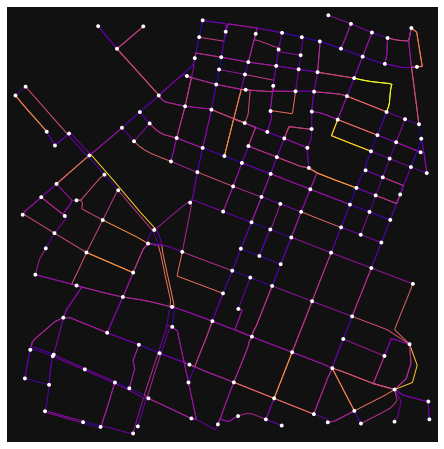

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [28]:
network = osm.add_edge_speeds(network, hwy_speeds={
    'residential': 30,
    'unclassified': 30,
    'tertiary': 50,
    'secondary': 70,
    'trunk': 120,
    'primary': 100,
    'motorway': 130
}, fallback=30)
# This adds a 'speed_kph' attribute to each edge
# We can use this to calculate the travel time
network = osm.add_edge_travel_times(network, precision=2)
osm.plot_graph(network, edge_color=osm.plot.get_edge_colors_by_attr(network, attr='travel_time', cmap="plasma"))

In [29]:
nodes, edges = osm.graph_to_gdfs(network)
edges.head(4)

/home/patrick/Code/live-coding-tutorial/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


osmid  oneway  \
u v  key                                                              
0 5  0                                             90394166    True   
  31 0    [59531576, 90394180, 93195112, 36996107, 31600...   False   
1 30 0                                [59988832, 160489258]    True   
  5  0                      [60734641, 67433180, 227043221]    True   

                                   name      highway maxspeed      length  \
u v  key                                                                    
0 5  0                     Arnulfstraße    secondary       50   99.245558   
  31 0    [Rundfunkplatz, Hopfenstraße]  residential       50  226.359834   
1 30 0              Zirkus-Krone-Straße  residential       50  129.838505   
  5  0                     Arnulfstraße    secondary       50  201.945694   

                                                   geometry  u_original  \
u v  key                                                                  
0 5  0    LINESTRING (689983.609 5335286.584, 689985.797...   309890165   
  31 0    LINESTRING (689983.609 5335286.584, 689985.797...   309890165   
1 30 0    LINESTRING (689714.230 5335362.532, 689715.670...   309889867   
  5  0    LINESTRING (689714.230 5335362.532, 689712.789...   814227811   

          v_original  speed_kph  travel_time lanes access tunnel width  
u v  key                                                                
0 5  0     309890117       50.0         7.15   NaN    NaN    NaN   NaN  
  31 0      21642946       50.0        16.30   NaN    NaN    NaN   NaN  
1 30 0      21619883       50.0         9.35   NaN    NaN    NaN   NaN  
  5  0    1022404024       50.0        14.54     2    NaN    NaN   NaN

### Getting fast-food restaurant locations

Similar to the waste disposal container case study, we fetch the geometries according to OSM *tags*:

In [32]:
shops_in_area = osm.geometries_from_address('Maxvorstadt, Munich, Germany', tags={
    'amenity': ['fast_food'] # 'restaurant'
})
# Project to meters
shops_in_area = osm.project_gdf(shops_in_area)

/home/patrick/Code/live-coding-tutorial/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['unique_id', 'osmid', 'element_type', 'addr:city', 'addr:country',
       'addr:housenumber', 'addr:postcode', 'addr:street', 'amenity',
       'cuisine', 'name', 'opening_hours', 'wheelchair', 'geometry',
       'delivery', 'delivery:partner', 'diet:vegetarian', 'phone', 'takeaway',
       'website', 'drive_through', 'email', 'outdoor_area', 'outdoor_seating',
       'contact:email', 'contact:phone', 'contact:website', 'indoor_seating',
       'wheelchair:description', 'smoking', 'fixme', 'payment:cash',
       'payment:ep_stwm_legic', 'amenity:disused', 'level', 'source', 'brand',
       'brand:wikidata', 'brand:wikipedia', 'layer', 'name:de', 'operator',
       'toilets:wheelchair', 'check_date:opening_hours', 'fax',
       'internet_access', 'diet:vegan', 'payment:credit_cards',
       'payment:debit_cards', 'opening_hours:covid19', 'nodes', 'building'],
      dtype='object')


In [33]:
# What does our data look like?
print(shops_in_area.columns)
shops_in_area[['osmid', 'name', 'addr:street', 'addr:housenumber', 'geometry']].tail(5)

/home/patrick/Code/live-coding-tutorial/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,osmid,name,addr:street,addr:housenumber,geometry
59,6406353537,Hanshe,NaN,NaN,POINT (691517.807 5336721.132)
60,7743860108,PIZZALAB,Gabelsbergerstraße,33,POINT (691123.446 5335816.299)
61,7939005507,Delicious Burger,Augustenstraße,107,POINT (690812.601 5336548.970)
62,8113005448,Manti Turkish Dumplings,NaN,NaN,POINT (691449.550 5336277.093)
63,273804417,BlackBox,Dachauer Straße,6,"POLYGON ((690467.666 5335271.661, 690468.870 5..."


/home/patrick/Code/live-coding-tutorial/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

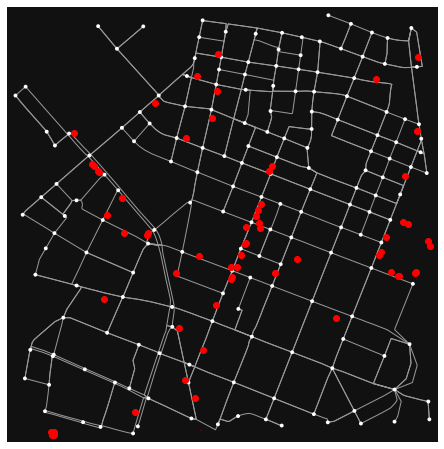

In [34]:
# Plot the locations on the street network
fig, ax = osm.plot_graph(network, show=False)
shops_in_area.plot(ax=ax, color='r')

### Mapping locations to the street network

This time, we need to determine the edges adjacent to each restaurant.

We could use the `get_nearest_edges()` function, but then we'd have only a single edge per restaurant.

Instead, we will "expand" the nodes to match the radius they cover, and then see which edges intersect these new geometric shapes.

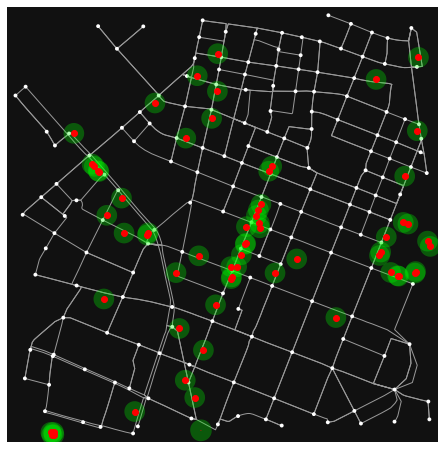

In [36]:
shops_in_area['vicinity'] = shops_in_area.buffer(distance=50)

fig, ax = osm.plot_graph(network, show=False, close=False)
shops_in_area['vicinity'].plot(ax=ax, alpha=0.3, color='#00ff00')
shops_in_area.plot(ax=ax, color='r')

plt.show()
plt.close(fig)

Finally, determine 

/home/patrick/Code/live-coding-tutorial/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

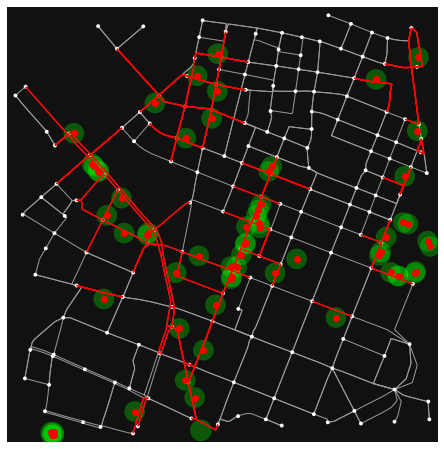

In [37]:
nodes, edges = osm.graph_to_gdfs(network)
edges['expensive'] = False
# Find edges in vicinity
for shop_id, shop in shops_in_area.iterrows():
    edges['expensive'] = edges['expensive'] | edges.geometry.crosses(shop.vicinity)
fig, ax = osm.plot_graph(network, show=False)
edges[edges['expensive']].plot(ax=ax, color='r')
shops_in_area['vicinity'].plot(ax=ax, alpha=0.3, color='#00ff00')
shops_in_area.plot(ax=ax, color='r')

### Assigning edge costs based on expensiveness

In [55]:
diet_factor = 10.0
edges['cost'] = edges['travel_time'] + (diet_factor * edges['travel_time'] * edges['expensive'])
nx.set_edge_attributes(network, values=edges['cost'], name = 'cost')
display(edges.tail(4))

/home/patrick/Code/live-coding-tutorial/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


osmid  oneway  \
u    v  key                                                              
0    5  0                                             90394166    True   
     31 0    [59531576, 90394180, 93195112, 36996107, 31600...   False   
1    30 0                                [59988832, 160489258]    True   
     5  0                      [60734641, 67433180, 227043221]    True   
2    8  0                                            144928572   False   
...                                                        ...     ...   
19-0 20 0                               [313579592, 313579587]    True   
19-1 30 0                                            153292468   False   
     33 0                               [313579600, 923478467]    True   
6-0  0  0                                 [90394166, 90394174]    True   
6-1  3  0                    [313579601, 122926430, 122926431]    True   

                                      name      highway maxspeed      length  \
u    v  key                                                                    
0    5  0                     Arnulfstraße    secondary       50   99.245558   
     31 0    [Rundfunkplatz, Hopfenstraße]  residential       50  226.359834   
1    30 0              Zirkus-Krone-Straße  residential       50  129.838505   
     5  0                     Arnulfstraße    secondary       50  201.945694   
2    8  0                       Amiraplatz  residential       30   86.805000   
...                                    ...          ...      ...         ...   
19-0 20 0                       Marsstraße    secondary       50  133.797452   
19-1 30 0              Zirkus-Krone-Straße  residential       50  140.137000   
     33 0                       Marsstraße    secondary       50  171.553854   
6-0  0  0                     Arnulfstraße    secondary       50  165.869736   
6-1  3  0                      Seidlstraße    secondary       50  150.723218   

                                                      geometry  u_original  \
u    v  key                                                                  
0    5  0    LINESTRING (689983.609 5335286.584, 689985.797...   309890165   
     31 0    LINESTRING (689983.609 5335286.584, 689985.797...   309890165   
1    30 0    LINESTRING (689714.230 5335362.532, 689715.670...   309889867   
     5  0    LINESTRING (689714.230 5335362.532, 689712.789...   814227811   
2    8  0    LINESTRING (691571.307 5335409.607, 691570.297...   612518275   
...                                                        ...         ...   
19-0 20 0    LINESTRING (689756.744 5335636.622, 689713.774...    21632162   
19-1 30 0    LINESTRING (689752.135 5335629.215, 689749.761...   358563818   
     33 0    LINESTRING (689752.135 5335629.215, 689835.508...   358563818   
6-0  0  0    LINESTRING (690141.055 5335254.940, 690131.980...    21324003   
6-1  3  0    LINESTRING (690164.205 5335289.121, 690170.597...  1710336183   

             v_original  speed_kph  travel_time   lanes access tunnel width  \
u    v  key                                                                   
0    5  0     309890117       50.0         7.15     NaN    NaN    NaN   NaN   
     31 0      21642946       50.0        16.30     NaN    NaN    NaN   NaN   
1    30 0      21619883       50.0         9.35     NaN    NaN    NaN   NaN   
     5  0    1022404024       50.0        14.54       2    NaN    NaN   NaN   
2    8  0       2038181       30.0        10.42     NaN    NaN    NaN   NaN   
...                 ...        ...          ...     ...    ...    ...   ...   
19-0 20 0      21326677       50.0         9.63  [3, 1]    NaN    NaN   NaN   
19-1 30 0      21619883       50.0        10.09     NaN    NaN    NaN   NaN   
     33 0     738257248       50.0        12.35       2    NaN    NaN   NaN   
6-0  0  0     309890165       50.0        11.94     NaN    NaN    NaN   NaN   
6-1  3  0        361786       50.0        10.85  [2, 4]    NaN    NaN   NaN   

          

### Routing according to diet costs

First, resolve our "query".

/home/patrick/Code/live-coding-tutorial/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


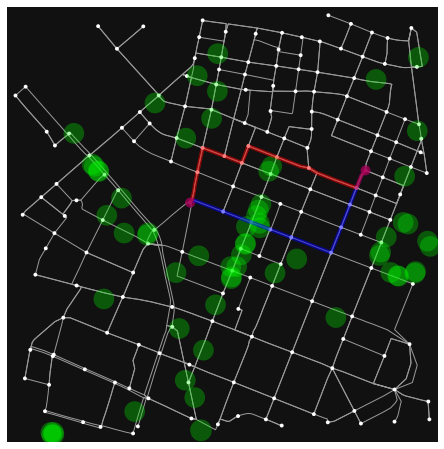

In [61]:
# Let's redo our shortest path query!
query = osm.project_gdf(osm.geocode_to_gdf([
    dict(street='45 Arcisstraße', city='Munich', country='Germany'),
    dict(street='8 Maßmannstraße', city='Munich', country='Germany')
], which_result=1))

university, park = (query.iloc[0], query.iloc[1])
university_node = osm.get_nearest_node(network, (university.geometry.centroid.coords[0][1], university.geometry.centroid.coords[0][0]), method='euclidean')
park_node = osm.get_nearest_node(network, (park.geometry.centroid.coords[0][1], park.geometry.centroid.coords[0][0]), method='euclidean')

Finally, we can use the "cost" attribute to find a shortest path!

In [ ]:
shortest_diet_path = osm.shortest_path(network, orig=university_node, dest=park_node, weight='cost')
shortest_path = osm.shortest_path(network, orig=university_node, dest=park_node, weight='travel_time')
fig, ax = osm.plot_graph_route(network, shortest_path, show=False, close=False, route_color='b')
osm.plot_graph_route(network, shortest_diet_path, ax=ax, show=False, close=False, route_color='r')
shops_in_area['vicinity'].plot(ax=ax, alpha=0.3, color='#00ff00')
plt.show()